In [16]:
import jax
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt
import cyipopt
jax.config.update("jax_enable_x64", True)

In [29]:
num_steps = 10
p_obs = jnp.array([0, 0.1])
r_obs = 0.2

dim_robot = 2
r_robot = 0.1
safe_dist = 0.05

q_init = jnp.array([-1, -1])
q_goal = jnp.array([1, 1])

In [18]:
# define robot
x_robot = r_robot*jnp.cos(jnp.linspace(0, jnp.pi*2, 10))
y_robot = r_robot*jnp.sin(jnp.linspace(0, jnp.pi*2, 10))
p_robot = jnp.vstack([x_robot, y_robot]).T

In [19]:
# util functions
dim = dim_robot*num_steps
def to_mat(x):
    return x.reshape(-1, dim_robot)
def at_timestep(i, x):
    return to_mat(x)[i]
def to_v(x):
    return (to_mat(x)[1:] - to_mat(x)[:-1]).flatten()

In [20]:
from signed_distance import *

# functions
def min_dist_cost(x):
    v = to_v(x)
    return v @ v

obs = Circle(p_obs, r_obs)
env = EnvSDF((obs,), safe_dist) # exclude r_robot in safe_dist
assign_points = lambda q: p_robot + q
assign_points_path = lambda x: jnp.vstack(jax.vmap(assign_points)(to_mat(x)))
penetration = lambda x: env.penetrations(assign_points_path(x))
# def ssdf_circle(point, center, r, safe_dist):
#     diff = point - center
#     return diff@diff - (safe_dist + r)**2

In [21]:
from functools import partial
# ssdf_obs_point = partial(ssdf_circle, center=p_obs, r=r_obs, safe_dist=safe_dist)
# ssdf_obs_robot = lambda pos: jax.vmap(ssdf_obs_point)(p_robot + pos).min()
# ssdf_obs_path = lambda x: jax.vmap(ssdf_obs_robot)(to_mat(x))
state_init = partial(at_timestep, 0)
state_goal = partial(at_timestep,-1)

In [22]:
g, cl, cu = [], [], []
f = min_dist_cost
g.append(state_init)
cl.extend(q_init)
cu.extend(q_init)
g.append(state_goal)
cl.extend(q_goal)
cu.extend(q_goal)
g.append(penetration)
cl.append(-jnp.inf)
cu.append(0.)

In [23]:
lb = jnp.full(dim, -1.) - 0.02
ub = jnp.full(dim, 1.) + 0.02
cl = jnp.array(cl)
cu = jnp.array(cu)
const_dim = len(cl)
_g = lambda x: jnp.hstack([fn(x) for fn in g])

In [24]:
x_rand = jnp.array(np.random.random(dim))
lambda_rand = jnp.array(np.random.random(const_dim))

fns = {}
fns['objective'] = f
fns['constraints'] = _g
fns['gradient'] = jax.grad(f)
fns['const_jacobian'] = jax.jacrev(_g)
fns['obj_hessian'] = jax.hessian(f)
fns['const_hessian'] = jax.hessian(_g)

def _hessian(x, lagrange, obj_factor):
    H = obj_factor * fns['obj_hessian'](x)
    H += jnp.einsum('i,ijk->jk', lagrange, fns['const_hessian'](x))
    return H
jac_row, jac_col = jnp.nonzero(fns['const_jacobian'](x_rand))
fns['jacobianstructure'] =  lambda : (jac_row, jac_col)
# hess_row, hess_col = jnp.nonzero(jnp.tril(_hessian(x_rand, lambda_rand, 1.)))
# fns['hessianstructure'] =  lambda : (hess_row, hess_col)
def jacobian(x):
    J = fns['const_jacobian'](x)
    row, col = fns['jacobianstructure']()
    return J[row, col]
def hessian(x, lagrange, obj_factor):
    H = _hessian(x, lagrange, obj_factor)
    #row, col = fns['hessianstructure']()
    return H #[row, col]
fns['jacobian'] = jacobian
fns['hessian'] = hessian 

In [25]:
class Prob:
    pass
prob = Prob()

for name, fn in fns.items():
    if name in ['objective', 'constraints', 'gradient', 'jacobian']:
        setattr(prob, name, jax.jit(fn).lower(x_rand).compile())
    elif 'structure' in name:
        setattr(prob, name, jax.jit(fn).lower().compile())
    elif name in ['hessian']:
        hess_fn = jax.jit(fn).lower(x_rand, lambda_rand, 1.).compile()
        setattr(prob, name, hess_fn)

solver = cyipopt.Problem(
    n=dim, m=const_dim,
    problem_obj=prob,
    lb=lb, ub=ub, cl=cl, cu=cu
)
solver.add_option('tol', 0.01)
solver.add_option("constr_viol_tol", 0.001)
#solver.add_option('hessian_approximation', 'limited-memory')

In [30]:
x0 = jnp.linspace(q_init, q_goal, num_steps).flatten()
xsol, info = solver.solve(x0)
#normal : 0.046

This is Ipopt version 3.14.10, running with linear solver MUMPS 5.2.1.

Number of nonzeros in equality constraint Jacobian...:        4
Number of nonzeros in inequality constraint Jacobian.:        4
Number of nonzeros in Lagrangian Hessian.............:      210

Total number of variables............................:       20
                     variables with only lower bounds:        0
                variables with lower and upper bounds:       20
                     variables with only upper bounds:        0
Total number of equality constraints.................:        4
Total number of inequality constraints...............:        1
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        1

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  8.8888889e-01 1.02e+00 9.81e-01  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

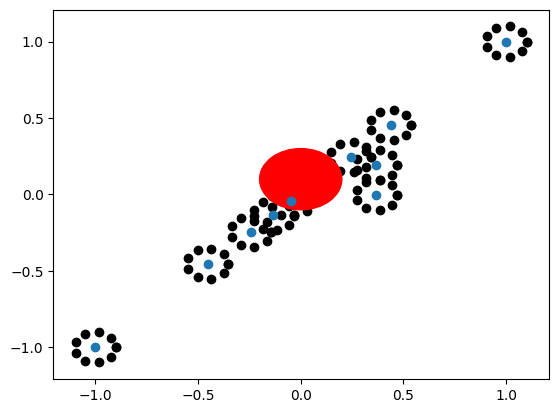

In [31]:
xs = to_mat(xsol)

fig, ax = plt.subplots()
robots = []
for x in xs:
    p = p_robot + x
    ax.scatter(*p.T, color='k')
circle = plt.Circle(p_obs, r_obs, color='r')
ax.add_patch(circle)
ax = plt.scatter(*xs.T)